In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))

from qubit_templates import *
from functions import *
from ChipDesign import *

# Read configuration file

In [3]:
JJtype = "manhattan" # manhattan or dolan

common_config = load_config( f"config/common.yaml" )
config = load_config( f"config/{JJtype}_2D_silicon.yaml" )
config = {**common_config, **config} # common config will be overwritten by value in the right 

DCLine = True # Add DC line next to squids
Entangle = False # Connect two transmons
SimulationDesign = True # Make inverted design for HFSS simulation (This takes a long time...)
QiskitDesign = True

outname = "waferdesign_2D_" + JJtype
if config["JJ_bandage"]:
    outname += "bd"
if DCLine:
    outname += "_dcline"
if Entangle:
    outname += "_entangle"    


# Wafer design

In [4]:
wafer = device_Wafer(config)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


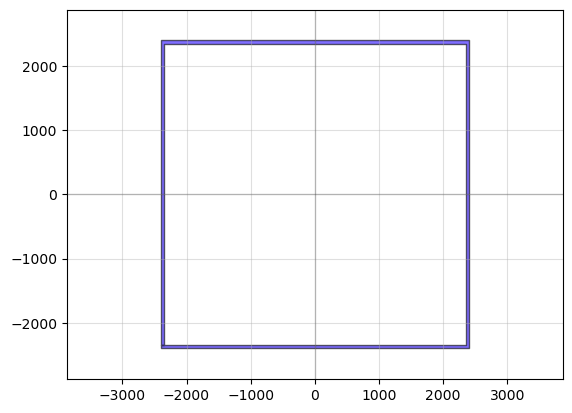

In [5]:
chipdesign = Device('chipdesign')

FM=device_Frame(config)
FM.center = (0, 0)

# Quickplot the imported design
qp(FM)

# Launch pad

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


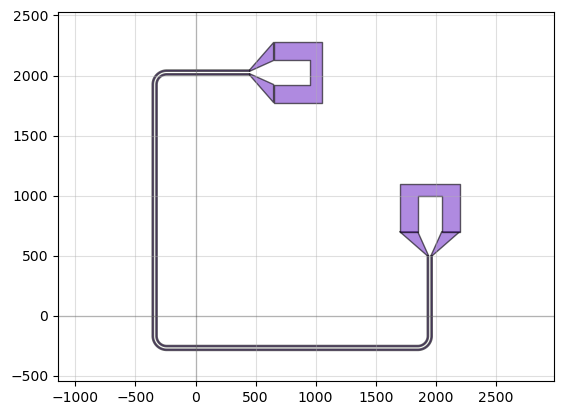

In [6]:
FL = device_FeedLine(config)
chipdesign.add_ref(FL.device)
qp(chipdesign)


# Corner points

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


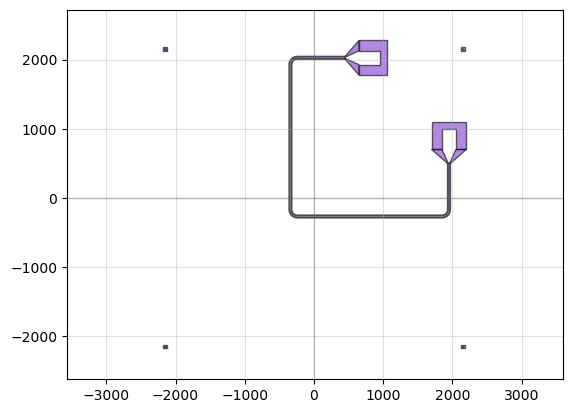

In [7]:
CP = device_CornerPoints(config)
chipdesign.add_ref(CP)
qp(chipdesign)

# Test Areas

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


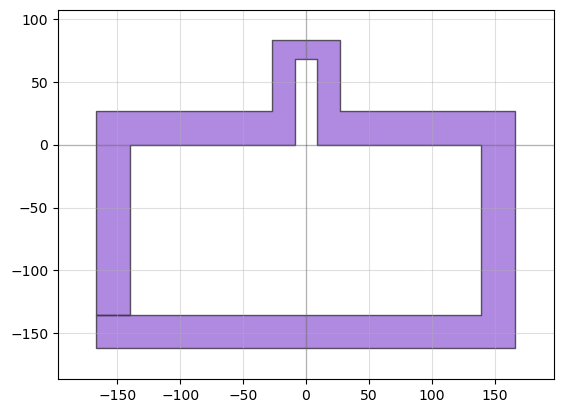

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


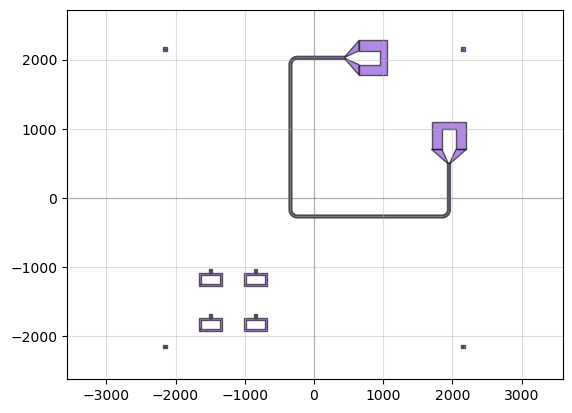

In [8]:
TA = device_TestAreas(config, DCLine = DCLine)
chipdesign.add_ref(TA)
qp(chipdesign)

# Resonator

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[Port (name out, midpoint [  0. -10.], width 10, orientation 270), Port (name entangle, midpoint [  0. 186.], width 10, orientation 90), Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270), Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)]
[Port (name out, midpoint [  0. -10.], width 10, orientation 270), Port (name entangle, midpoint [  0. 186.], width 10, orientation 90), Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270), Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)]
[Port (name out, midpoint [  0. -10.], width 10, orientation 270), Port (name entangle, midpoint [  0. 186.], width 10, orientation 90), Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270), Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)]
[Port (name out, midpoint [  0. -10.], width 10, orientation 270), Port (name entangle, midpoint [  0. 186.], width 10, orientation 90), Port (name Juncti

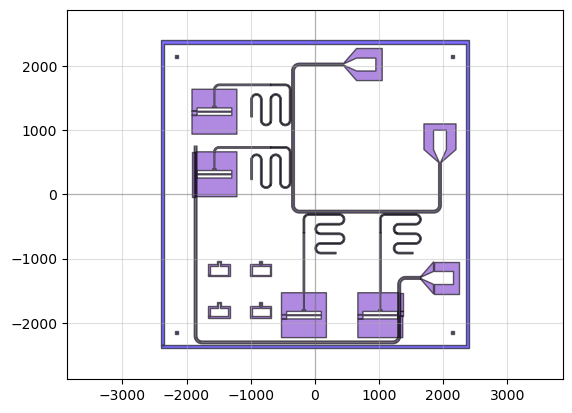

In [9]:
resonator_config = dict(
    resonator_straight1 = 220, 
    resonator_straight2 = 260, 
    resonator_straight3 = 475, 
    resonator_straight4 = 1400, 
    entangle = Entangle,
)

R1 = device_Resonator(config, **resonator_config)
R1.movex(1315)
R1.ymax = FL.ymin - config["Feedline_Resonator_gap"]
chipdesign.add_ref(R1.device)

resonator_config.update(
    resonator_straight1 = 240, 
    resonator_straight2 = 290, 
    resonator_straight3 = 475, 
    resonator_straight4 = 1400, 
)

R2 = device_Resonator(config, **resonator_config)
R2.movex(145)
R2.ymax = FL.ymin - config["Feedline_Resonator_gap"]
chipdesign.add_ref(R2.device)

resonator_config.update(
    resonator_straight1 = 310, 
    resonator_straight2 = 360, 
    resonator_straight3 = 475, 
    resonator_straight4 = 1030,
    side = True,
    mirror = Entangle,
)

R3 = device_Resonator(config, **resonator_config)
R3.movey(408)
R3.xmax = FL.xmin - config["Feedline_Resonator_gap"]
chipdesign.add_ref(R3.device)

resonator_config.update(
    resonator_straight1 = 275, 
    resonator_straight2 = 325, 
    resonator_straight3 = 475, 
    resonator_straight4 = 1030,
    side = True,
    mirror = False
)

R4 = device_Resonator(config, **resonator_config)
R4.movey(1383)
R4.xmax = FL.xmin - config["Feedline_Resonator_gap"]
chipdesign.add_ref(R4.device)

if Entangle:

    config = dict(
        port1 = R1.device.references[1].ports['entangle'],
        port2 = R2.device.references[1].ports['entangle'],
        radius = 75,
        path_type = 'U',
        length1 = 120 + 75,
        smooth_options=  {'corner_fun': pp.arc}
    )
    line_1to2 = device_EntangleLine( config )

    config = dict(
        port1 = R3.device.references[1].ports['entangle'],
        port2 = R4.device.references[1].ports['entangle'],
        path_type = 'straight'
    )    
    line_3to4 = device_EntangleLine( config )   

    chipdesign = pg.boolean(chipdesign, line_1to2.metal , 'not', layer = 4)
    chipdesign = pg.boolean(chipdesign, line_3to4.metal , 'not', layer = 4)
    chipdesign.add_ref( line_1to2.device )
    chipdesign.add_ref( line_3to4.device )


if DCLine:
    DC = device_DCLine(config) 
    chipdesign = pg.boolean(chipdesign, DC.metal, 'not', layer = 4)
    chipdesign.add_ref(DC.device)

chipdesign.add_ref(FM)
chipdesign.write_gds('output/dcline.gds')
qp(chipdesign)

## Make inverted design for simulation

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


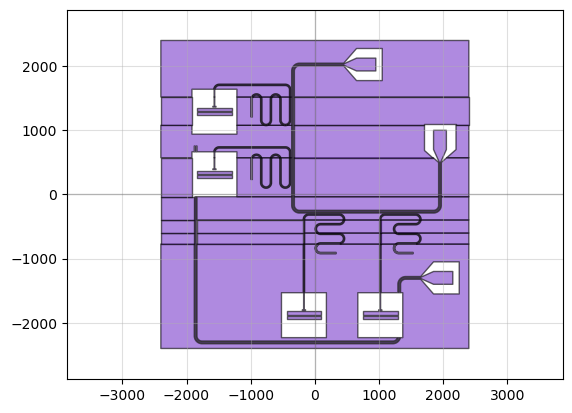

In [10]:
if SimulationDesign:
    # Produce inverted version for simulation
    chipdesign_inverted = Device('chipdesign_inverted')
    chipdesign_inverted.add_ref(FL.device)
    chipdesign_inverted.add_ref(R1.device)
    chipdesign_inverted.add_ref(R2.device)
    chipdesign_inverted.add_ref(R3.device)
    chipdesign_inverted.add_ref(R4.device)
    # chipdesign_inverted.add_ref(CP)
    # chipdesign_inverted.add_ref(TA)
    if DCLine:
        chipdesign_inverted.add_ref(DC.device)
    if Entangle:
        chipdesign_inverted.add_ref(line_1to2.device)
        chipdesign_inverted.add_ref(line_3to4.device)

    rectangle = pg.bbox([(-2400, -2400),(2400, 2400)], 0)
    trace = pg.copy_layer(chipdesign_inverted, 1, config["Resonator_layer"])
    chipdesign_inverted = pg.boolean(rectangle, chipdesign_inverted, operation = 'not', layer = config["Resonator_layer"])
    chipdesign_inverted.add_ref(trace)

    qp(chipdesign_inverted)

    chipdesign_inverted.write_gds('output/chipdesign_simulation.gds')

## Make inverted design for Qiskit-metal

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


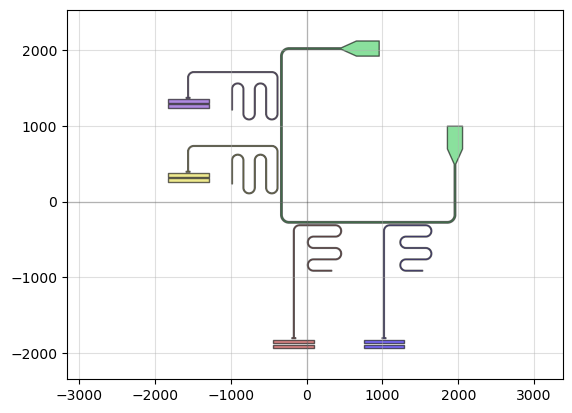

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


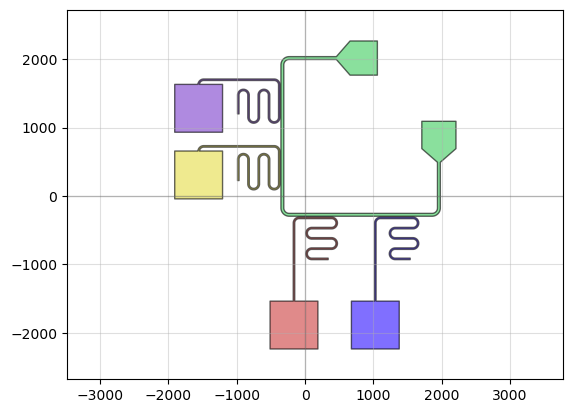

{'FeedLine': {'layer': 0, 'ports': {'LaunchPad0': {'start': [1050.0, 1925.0], 'end': [1050.0, 2125.0], 'width': 200.0, 'gap': 100.0}, 'LaunchPad1': {'start': [2050.0, 1100.0], 'end': [1850.0, 1100.0], 'width': 200.0, 'gap': 100.0}}}, 'Qubit1': {'layer': 1, 'jj': {'start': [1020.0, -1889.0], 'end': [1020.0, -1873.0], 'width': 10.0}}, 'Qubit2': {'layer': 2, 'jj': {'start': [-170.0, -1889.0], 'end': [-170.0, -1873.0], 'width': 10.0}}, 'Qubit3': {'layer': 3, 'jj': {'start': [-1565.0000000000005, 307.0], 'end': [-1565.0000000000005, 323.0], 'width': 10.0}}, 'Qubit4': {'layer': 4, 'jj': {'start': [-1565.0000000000005, 1282.0], 'end': [-1565.0000000000005, 1298.0], 'width': 10.0}}}


In [11]:
if QiskitDesign:

    device_list = [
        dict(device = FL, name = "FeedLine"),
        dict(device = R1, name = "Qubit1"),    
        dict(device = R2, name = "Qubit2"),
        dict(device = R3, name = "Qubit3"),    
        dict(device = R4, name = "Qubit4"),
    ]

    if Entangle:
        device_list.extend([ 
            dict(device = line_1to2, name = "Entangle1to2"),
            dict(device = line_3to4, name = "Entangle3to4")
        ])

    phidl_to_metal(
        device_list = device_list, 
        outname = "chipdesign"
    )
     

# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


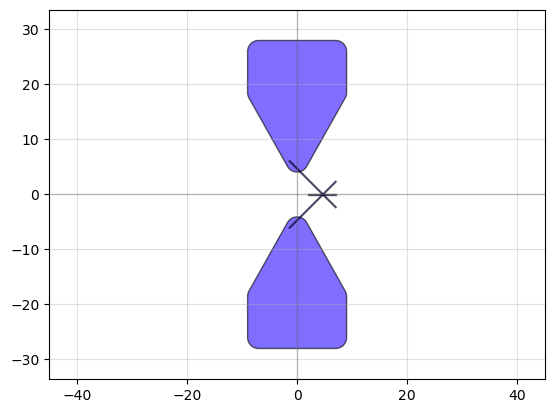

In [12]:
JJ = device_JJ(config)
qp(JJ)


# Add test boxes for EB

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


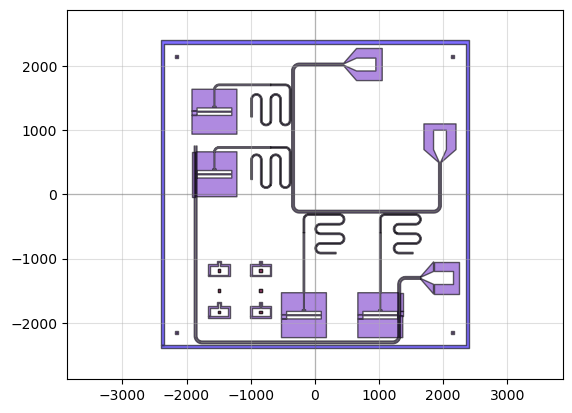

In [13]:
BX = device_TestBoxes(DCLine = DCLine)
chipdesign.add_ref(BX)
qp(chipdesign)

# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


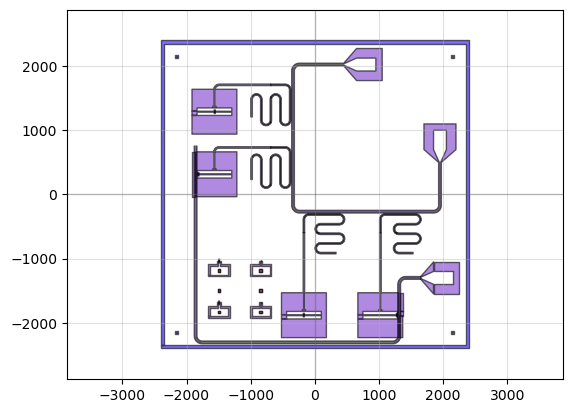

'output/chipdesign.gds'

In [14]:
def chipdesign_transmon2D(config, param_x = None, param_y = None, x = None, y = None, only_frame = False):

    init_chipdesign(config, param_x, param_y, x, y)
    
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ_trans = device_JJ({**config, **dict(JJ_squid = False)})          
    JJ_squid = device_JJ({**config, **dict(JJ_squid = True)})  

    EBLine = device_EBLine(config)

    # SQUID
    chip.add_ref(JJ_squid).movex(1280).movey(-1880)
    # transmon
    chip.add_ref(JJ_trans).movex(-172).movey(-1880)
    # SQUID
    chip.add_ref(JJ_squid).movex(-1815).movey(315)    
    # transmon
    chip.add_ref(JJ_trans).movex(-1560).movey(1290)

    # transmon (test)
    if DCLine:
        chip.add_ref(JJ_trans).movex(-1493).movey(-1689)
        chip.add_ref(JJ_trans).movex(-1493).movey(-1038)
        chip.add_ref(EBLine).movex(-843).movey(-1689)
        chip.add_ref(EBLine).movex(-843).movey(-1038)
    else:
        chip.add_ref(JJ_trans).movex(-1743).movey(-1739)
        chip.add_ref(JJ_trans).movex(-1743).movey(-1088)
        chip.add_ref(EBLine).movex(-1093).movey(-1739)
        chip.add_ref(EBLine).movex(-1093).movey(-1088)    

    return chip

chip = chipdesign_transmon2D(config)
qp(chip)
chip.write_gds('output/chipdesign')

# Place chip designs

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


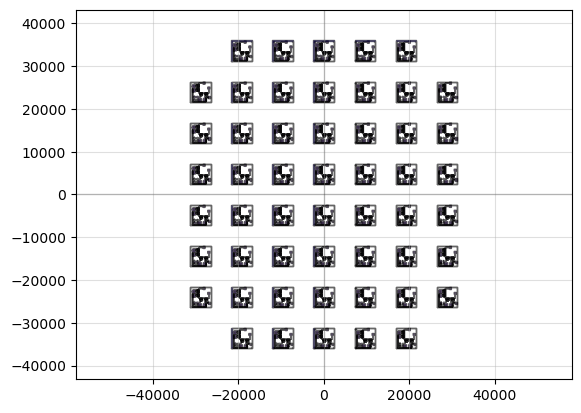

In [15]:
D = sweep_chipdesign( config, userfunction = chipdesign_transmon2D )
D.center = (0,0)

## Remove corners
Grid_width = config["Grid_sweep_array"][0]["x"]
Grid_height = config["Grid_sweep_array"][0]["y"]
for iref, ref in enumerate(D.references[:]):
    if iref == 0 or iref == len(Grid_width)-1 or iref == len(Grid_width) * (len(Grid_height)-1) or iref == len(Grid_width) * len(Grid_height) - 1:
        D.remove(ref)

wafer.add_ref(D)
qp(D)


# Add EB markers

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


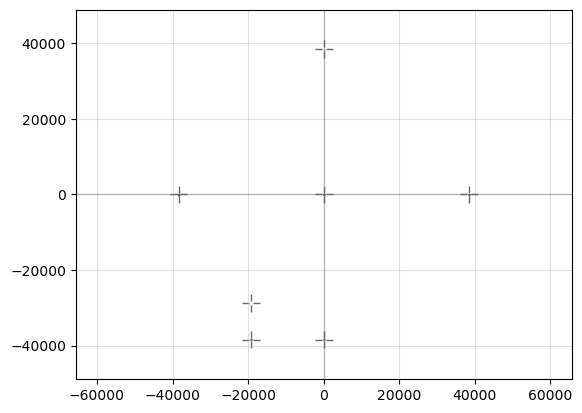

DeviceReference (parent Device "EBmarkers", ports [], origin (0, 0), rotation 0, x_reflection False)

In [16]:
EBmarkers = device_EBmarkers(marker_pos = config["EBMarker_pos"], layer = config["EBMarker_layer"])
qp(EBmarkers)
wafer.add_ref(EBmarkers)


# Add grid lines

13 15


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


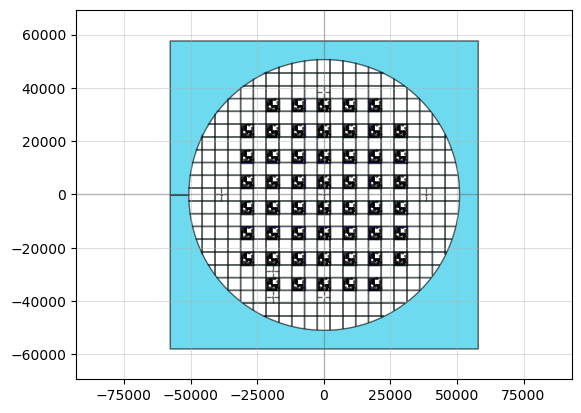

In [17]:
grid = device_Grid(config)
wafer.add_ref( grid )

qp(wafer)


In [18]:
wafer.write_gds('output/' + outname)

'output/waferdesign_2D_manhattan_dcline.gds'